## Read Dataset <a class="anchor" name="part_00"></a>

In [2]:
from google.colab import drive

from tensorflow.keras import layers, Sequential, Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose, RandomVerticalFlip, RandomHorizontalFlip, RandomPerspective, RandomInvert, RandomAutocontrast

drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Dataset'
files = os.listdir(drive_path)
print(files)

Mounted at /content/drive
['val', 'test', 'train', 'model_history', 'model_best.pth', 'annotated_images']


In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

def get_dataset_split_tensorflow(directory, image_size=(256, 256), batch_size=32):

    train_data = image_dataset_from_directory(
        directory=f'{directory}/train',
        label_mode='binary',
        image_size=image_size,
        batch_size=batch_size
    )

    val_data = image_dataset_from_directory(
        directory=f'{directory}/val',
        label_mode='binary',
        image_size=image_size,
        batch_size=batch_size
    )

    test_data = image_dataset_from_directory(
        directory=f'{directory}/test',
        label_mode='binary',
        image_size=image_size,
        batch_size=batch_size
    )

    return train_data, val_data, test_data


dataset_path = '/content/drive/MyDrive/Dataset'

train_data, val_data, test_data = get_dataset_split_tensorflow(dataset_path)

print("Train data info:", train_data)
print("Validation data info:", val_data)
print("Test data info:", test_data)

for images, labels in train_data.take(1):
    print("Train images shape:", images.shape)
    print("Train labels shape:", labels.shape)

for images, labels in val_data.take(1):
    print("Validation images shape:", images.shape)
    print("Validation labels shape:", labels.shape)

for images, labels in test_data.take(1):
    print("Test images shape:", images.shape)
    print("Test labels shape:", labels.shape)


Found 1419 files belonging to 2 classes.
Found 337 files belonging to 2 classes.
Found 297 files belonging to 2 classes.
Train data info: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Validation data info: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Test data info: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Train images shape: (32, 256, 256, 3)
Train labels shape: (32, 1)
Validation images shape: (32, 256, 256, 3)
Validation labels shape: (32, 1)
Test images shape: (32, 256, 256, 3)
Test labels shape: (32, 1)


In [4]:




import os
import numpy as np
import matplotlib.pyplot as plt

def plot_history(history, title='CNN', save_data=True):

    dataset_path = '/content/drive/MyDrive/Dataset'
    save_dir = os.path.join(dataset_path, 'model_history', title)


    os.makedirs(save_dir, exist_ok=True)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].plot(history['accuracy'], label='train')
    ax[0].plot(history['val_accuracy'], label='val')
    ax[0].set_title('Model Accuracy'); ax[0].set_ylabel('Accuracy'); ax[0].set_xlabel('Epoch')
    ax[0].legend(); ax[0].grid()


    ax[1].plot(history['loss'], label='train')
    ax[1].plot(history['val_loss'], label='val')
    ax[1].set_title('Model Loss'); ax[1].set_ylabel('Loss'); ax[1].set_xlabel('Epoch')
    ax[1].legend(); ax[1].grid()


    ax[2].plot(history['get_f1'], label='train')
    ax[2].plot(history['val_get_f1'], label='val')
    ax[2].set_title('Model F1 Score'); ax[2].set_ylabel('F1'); ax[2].set_xlabel('Epoch')
    ax[2].legend(); ax[2].grid()


    plot_path = os.path.join(save_dir, f'{title}.png')
    plt.savefig(plot_path)
    plt.show()


    if save_data:
        history_path = os.path.join(save_dir, f'{title}.npy')
        np.save(history_path, history)
        print(f"History saved to {history_path}")
        print(f"Plot saved to {plot_path}")





In [5]:
import tensorflow as tf
from keras import backend as K

def get_recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def get_precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def get_f1(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


## CNN (from scratch) <a class="anchor" name="part_01"></a>

### Model Structure

In [6]:


from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, RandomFlip, RandomRotation, RandomZoom
from keras import initializers
from keras.models import Model

def data_augmentation(inputs):

    x = RandomFlip('horizontal')(inputs)
    x = RandomRotation(0.2)(x)  # Randomly rotate the images by up to 20 degrees
    x = RandomZoom(0.2)(x)  # Randomly zoom the images by up to 20%
    return x

def CNNmodel(input_shape):
    inputs = Input(shape=input_shape+(3,))
    x = data_augmentation(inputs)

    # 1st Convolutional Layer
    x = Conv2D(16, 3, strides = 2, kernel_initializer = 'he_uniform',
               bias_initializer = initializers.Zeros(), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides = 1, padding = 'same')(x)

    # 2nd Convolutional Layer
    x = Conv2D(32, 3, strides = 2, kernel_initializer = 'he_uniform',
               bias_initializer = initializers.Zeros(), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides = 1, padding = 'same')(x)

    # 3rd Convolutional Layer
    x = Conv2D(64, 3, strides = 2, kernel_initializer = 'he_uniform',
               bias_initializer = initializers.Zeros(), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides = 1, padding = 'same')(x)

    # 4th Convolutional Layer
    x = Conv2D(64, 3, strides = 2, kernel_initializer = 'he_uniform',
               bias_initializer = initializers.Zeros(), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides = 1, padding='same')(x)

    # Passing it to a Fully Connected layer
    x = Flatten()(x)

    # 1st Fully Connected Layer
    x = Dense(256, kernel_initializer = 'he_uniform',
              bias_initializer=initializers.Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output Layer
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs, outputs)

# Assuming input_shape is (256, 256)
model = CNNmodel(input_shape=(256, 256))
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,257,057 (16.24 MB)

 Trainable params: 4,256,193 (16.24 MB)

 Non-trainable params: 864 (3.38 KB)

### Train

In [ ]:


from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set up the optimizer and loss function
optimizer = optimizers.Adam()
loss = "binary_crossentropy"

# Set up the callbacks
callbacks = [
    ModelCheckpoint(f'{dataset_path}/model_history/CNN/CNN.keras', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor="val_loss", min_delta=0.001, patience=100)
]

# Compile the model with the optimizer, loss, and custom metrics
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', get_f1, get_precision, get_recall])

# Fit the model
history = model.fit(
    train_data_tensorflow,            # Training data
    epochs=45,                         # Number of epochs
    callbacks=callbacks,              # Callbacks for saving the model and early stopping
    validation_data=val_data_tensorflow  # Validation data
)




Epoch 1/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.5167 - get_f1: 0.5487 - get_precision: 0.5285 - get_recall: 0.5855 - loss: 1.1224 - val_accuracy: 0.5223 - val_get_f1: 0.5668 - val_get_precision: 0.5760 - val_get_recall: 0.5633 - val_loss: 2.0399
Epoch 2/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5262 - get_f1: 0.5344 - get_precision: 0.5269 - get_recall: 0.5545 - loss: 0.7051 - val_accuracy: 0.5638 - val_get_f1: 0.6849 - val_get_precision: 0.5822 - val_get_recall: 0.8471 - val_loss: 1.1021
Epoch 3/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.5782 - get_f1: 0.6093 - get_precision: 0.5833 - get_recall: 0.6598 - loss: 0.6901 - val_accuracy: 0.5727 - val_get_f1: 0.5646 - val_get_precision: 0.6821 - val_get_recall: 0.5038 - val_loss: 0.8529
Epoch 4/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.5433 - get_f1: 0.5623 - get_precision: 0.5287 - get_recall: 0.6166 - loss: 0.7043 - val_accuracy: 0.4421 - val_get_f1: 0.1246 - val_get_precision:

### Load Model (for Test)

In [8]:
from keras.models import load_model

cnn = load_model('/content/drive/MyDrive/Dataset/model_history/CNN/CNN.keras',
                 custom_objects={'get_f1': get_f1, 'get_precision': get_precision, 'get_recall': get_recall})


In [10]:

history = np.load(f'{dataset_path}/model_history/CNN/CNN.npy', allow_pickle=True)
history = history.tolist()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
0.7311501
The image is real.


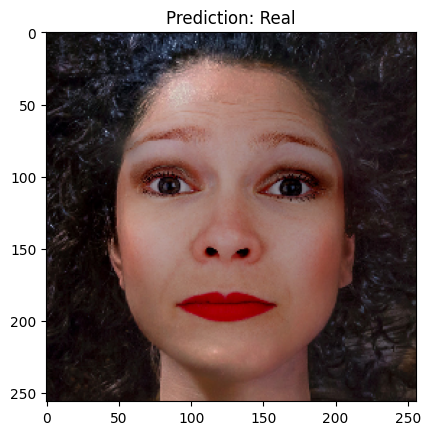

In [11]:



from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = f'{dataset_path}/train/fake/easy_2_1111.jpg'
img = image.load_img(img_path, target_size=(256, 256))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

prediction = cnn.predict(img_array)
print(prediction[0][0])

if prediction[0][0] >= 0.7:
    print("The image is real.")
elif prediction <= 0.4:
    print("The image is fake.")
else:
    print("The image is mid fake.")


plt.imshow(img)
plt.title(f"Prediction: {'Real' if prediction >= 0.7 else 'Fake' if prediction <= 0.4 else 'Mid Fake'}")
plt.show()


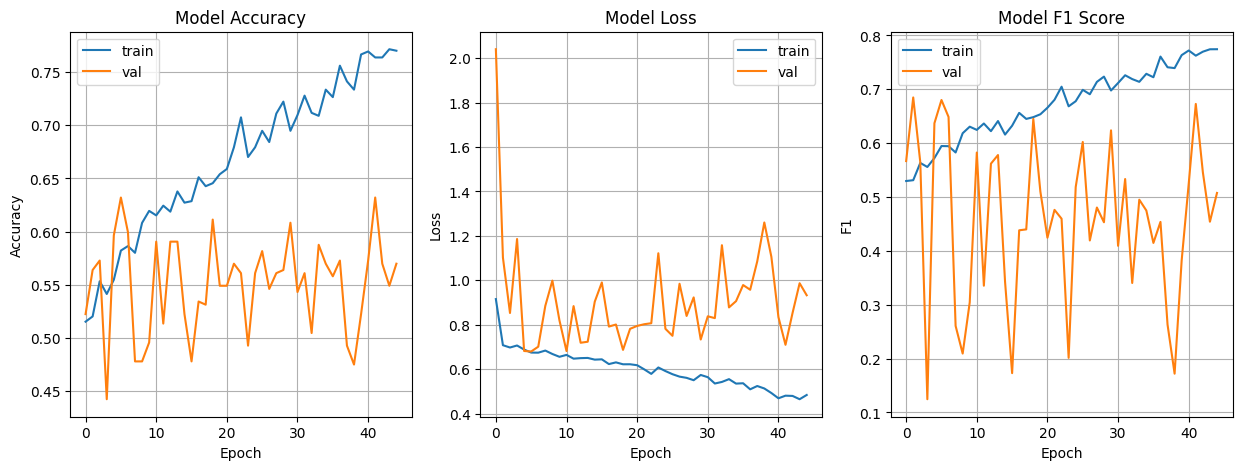

In [ ]:
plot_history(history, save_data=False)

# prediction on test data

In [15]:


predictions = []
for img, _ in test_data.take(1):
    pred = cnn.predict(img)
    print("hello",pred)
    predictions.extend(pred.flatten())  # Flatten the predictions
    if prediction >= 0.95:
        pred_label = "Real"
        print(pred_label)
    elif prediction <= 0.4:
        pred_label = "Fake"
        print(pred_label)
    else:
        pred_label = "Mid Fake"
        print(pred_label)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
hello [[0.3634644 ]
 [0.12524748]
 [0.7526427 ]
 [0.6093976 ]
 [0.7341593 ]
 [0.56685406]
 [0.85960513]
 [0.5609087 ]
 [0.60598123]
 [0.52503854]
 [0.4942855 ]
 [0.75052255]
 [0.23598245]
 [0.31833583]
 [0.58770573]
 [0.7040748 ]
 [0.8114307 ]
 [0.30616888]
 [0.8748203 ]
 [0.31467828]
 [0.32255083]
 [0.7234412 ]
 [0.25888783]
 [0.7384092 ]
 [0.76466227]
 [0.5405735 ]
 [0.8358708 ]
 [0.75562066]
 [0.5074984 ]
 [0.425139  ]
 [0.41038755]
 [0.3844453 ]]
Mid Fake
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
hello [[0.39215112]
 [0.14171214]
 [0.56432027]
 [0.70428556]
 [0.7220524 ]
 [0.79751384]
 [0.5004645 ]
 [0.438657  ]
 [0.7281925 ]
 [0.4311595 ]
 [0.4748601 ]
 [0.6084114 ]
 [0.5409193 ]
 [0.28349492]
 [0.4377974 ]
 [0.7953418 ]
 [0.26308206]
 [0.34535784]
 [0.6561539 ]
 [0.6271106 ]
 [0.2590006 ]
 [0.7571433 ]
 [0.6754518 ]
 [0.83422875]
 [0.3383612 ]
 [0.74044144]
 [0.43930444]
 [0.43836954]
 [0.80116236]
 [0.35065123]
 [0.46538422]
 [0.30387345]]
Mid F

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.73165375


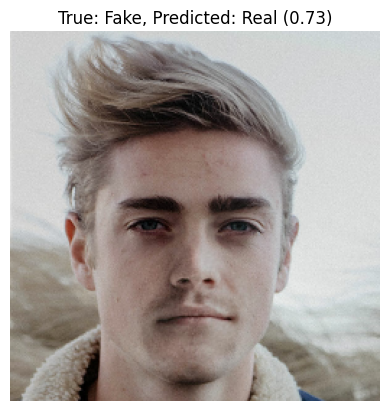

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0.73205686


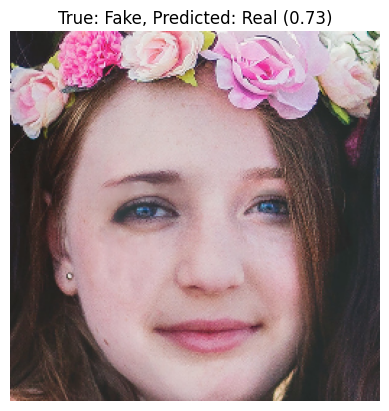

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.7317025


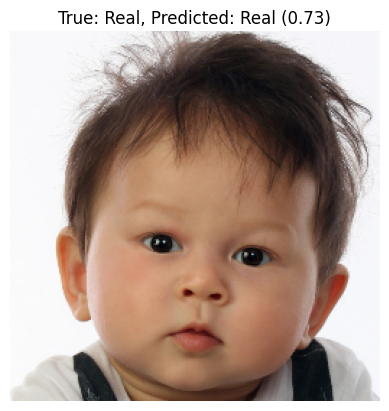

In [17]:
for img, label in test_data.take(3):
    img_array = img[0].numpy().astype("uint8")
    true_label = label[0].numpy()

    img_for_prediction = np.expand_dims(img[0].numpy() / 255.0, axis=0)  # Normalize and add batch dimension


    prediction = cnn.predict(img_for_prediction)[0][0]
    print(prediction)

    if prediction >= 0.7:
        pred_label = "Real"
    elif prediction <= 0.4:
        pred_label = "Fake"
    else:
        pred_label = "Mid Fake"


    plt.imshow(img_array)
    plt.title(f"True: {'Real' if true_label == 1 else 'Fake'}, Predicted: {pred_label} ({prediction:.2f})")
    plt.axis("off")
    plt.show()


In [18]:
def preprocess_image(img_path, target_size=(256, 256)):
    from tensorflow.keras.preprocessing import image


    img = image.load_img(img_path, target_size=target_size)

    img_array = image.img_to_array(img)

    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    return img_array
img_path = f'{dataset_path}/test/fake/mid_214_1011.jpg'
img_array = preprocess_image(img_path, target_size=(256, 256))

prediction = cnn.predict(img_array)
print(f"Prediction value: {prediction}")

if prediction >= 0.7:
    print("The image is real.")
elif prediction <= 0.4:
    print("The image is fake.")
else:
    print("The image is mid fake.")
predictions = []
for img_batch, _ in test_data.take(1):
    pred = cnn.predict(img_batch)
    predictions.extend(pred.flatten())
print("Batch predictions:", predictions)
for prediction in predictions:
    if prediction >= 0.7:
        pred_label = "Real"
    elif prediction <= 0.4:
        pred_label = "Fake"
    else:
        pred_label = "Mid Fake"
    print(f"Prediction value: {prediction}, Label: {pred_label}")
data_augmentation = Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
])
print(f"Single image range: {img_array.min()} to {img_array.max()}")
for img_batch, _ in test_data.take(1):
    print(f"Dataset batch range: {img_batch.numpy().min()} to {img_batch.numpy().max()}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction value: [[0.7318697]]
The image is real.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Batch predictions: [0.91233915, 0.45481697, 0.6400127, 0.85960513, 0.37757793, 0.777669, 0.46538422, 0.57559156, 0.40617198, 0.6271106, 0.49793392, 0.75795335, 0.8211209, 0.6084114, 0.7103323, 0.513321, 0.61668116, 0.30387345, 0.47916475, 0.52503854, 0.83422875, 0.32228982, 0.3959465, 0.24898632, 0.61893183, 0.26140267, 0.22105701, 0.43115717, 0.80575436, 0.12524748, 0.6093976, 0.43930444]
Prediction value: 0.9123391509056091, Label: Real
Prediction value: 0.4548169672489166, Label: Mid Fake
Prediction value: 0.6400126814842224, Label: Mid Fake
Prediction value: 0.8596051335334778, Label: Real
Prediction value: 0.37757793068885803, Label: Fake
Prediction value: 0.7776690125465393, Label: Real
Prediction value: 0.46538421511650085, Label: Mid Fake
Prediction value: 0.5755915641784668, Label: Mid Fake
Prediction value: 0.406171977519989, Label: Mid Fake
Predictio